In [40]:
import openpyxl as oxl
import pandas as pd
import numpy as np
import geopandas as gpd

from thefuzz import process as fzproc
from thefuzz import fuzz

import pathlib as plb

In [2]:
WORK_DIR = plb.Path().resolve().parent
INPUT_DIR = WORK_DIR / "data_inputs"
OUTPUT_DIR = WORK_DIR / "data_outputs"
NOTEBOOK_DIR = WORK_DIR / "notebooks"
SCRIPTS_DIR = WORK_DIR / "scripts"
PSGC_DIR = WORK_DIR.parent.parent / "E- Administrative Boundaries"
BOUNDS_DIR = WORK_DIR.parent.parent / "E- Administrative Boundaries" / "phl_adm_psa_namria_20231106_shp"

In [3]:
import sys
sys.path.append(str(WORK_DIR))

from scripts import parse_cph_excel as pcxl
from scripts import preprocess_geolocation as pgeo

In [4]:
fp_cph_2b = INPUT_DIR / "2020 Report 2B_Attachment_Housing.xlsx"
assert fp_cph_2b.exists()

In [5]:
fp_psgc = PSGC_DIR / "PSGC-1Q-2023-Publication-Datafile.xlsx"
assert fp_psgc.exists()

In [6]:
fp_ab3 = BOUNDS_DIR / "phl_admbnda_adm3_psa_namria_20231106.shp"
assert fp_ab3.exists()

In [7]:
target_sheet = "T5"

kwargs = {
    "start_row": 12,
    "n_footers": 5,
}

In [8]:
workbook = oxl.load_workbook(fp_cph_2b)
sheet = workbook[target_sheet]

In [9]:
sheet_full = pcxl.remove_blank_rows(sheet, **kwargs)

In [10]:
col_names = pd.read_excel(
    fp_psgc,
    sheet_name="PSGC",
    nrows=2
).columns.values.tolist()

col_names

['10-digit PSGC',
 'Name',
 'Correspondence Code',
 'Geographic Level',
 'Old names',
 'City Class',
 'Income\nClassification',
 'Urban / Rural\n(based on 2020 CPH)',
 '2015 Population',
 'Unnamed: 9',
 '2020 Population',
 'Unnamed: 11',
 'Status']

In [11]:
df_psgc = pd.read_excel(
    fp_psgc,
    sheet_name="PSGC",
    nrows=43789,
    dtype={col: str for col in col_names[:-5]}
)

df_psgc.head()

,10-digit PSGC,Name,Correspondence Code,Geographic Level,Old names,City Class,Income\nClassification,Urban / Rural\n(based on 2020 CPH),2015 Population,Unnamed: 9,2020 Population,Unnamed: 11,Status
0,0100000000,Region I (Ilocos Region),010000000,Reg,NaN,NaN,NaN,NaN,5026128,NaN,5301139,NaN,NaN
1,0102800000,Ilocos Norte,012800000,Prov,NaN,NaN,1st,NaN,593081,NaN,609588,NaN,NaN
2,0102801000,Adams,012801000,Mun,NaN,NaN,5th,NaN,1792,NaN,2189,NaN,NaN
3,0102801001,Adams,012801001,Bgy,NaN,NaN,NaN,R,1792,NaN,2189,NaN,Pob.
4,0102802000,Bacarra,012802000,Mun,NaN,NaN,3rd,NaN,32215,NaN,33496,NaN,NaN


In [12]:
cities = pcxl.get_column_from_sheet(sheet_full, 1, substr="CITY", **kwargs)
cities

['CITY OF MANILA',
 'CITY OF MANDALUYONG',
 'CITY OF MARIKINA',
 'CITY OF PASIG',
 'QUEZON CITY',
 'CITY OF SAN JUAN',
 'CITY OF CALOOCAN',
 'CITY OF MALABON',
 'CITY OF NAVOTAS',
 'CITY OF VALENZUELA',
 'CITY OF LAS PIÑAS',
 'CITY OF MAKATI',
 'CITY OF MUNTINLUPA',
 'CITY OF PARAÑAQUE',
 'PASAY CITY',
 'CITY OF TAGUIG',
 'CITY OF BAGUIO',
 'CITY OF TABUK (Capital)',
 'CITY OF BATAC',
 'CITY OF LAOAG (Capital)',
 'CITY OF CANDON',
 'CITY OF VIGAN (Capital)',
 'CITY OF SAN FERNANDO (Capital)',
 'CITY OF ALAMINOS',
 'CITY OF DAGUPAN',
 'CITY OF SAN CARLOS',
 'CITY OF URDANETA',
 'TUGUEGARAO CITY (Capital)',
 'CITY OF CAUAYAN',
 'CITY OF ILAGAN (Capital)',
 'CITY OF SANTIAGO',
 'CITY OF BALANGA (Capital)',
 'CITY OF MALOLOS (Capital)',
 'CITY OF MEYCAUAYAN',
 'CITY OF SAN JOSE DEL MONTE',
 'CITY OF CABANATUAN',
 'CITY OF GAPAN',
 'SCIENCE CITY OF MUÑOZ',
 'CITY OF PALAYAN (Capital)',
 'SAN JOSE CITY',
 'MABALACAT CITY',
 'CITY OF SAN FERNANDO (Capital)',
 'CITY OF ANGELES',
 'CITY OF TARL

In [13]:
hucs = pcxl.get_huc_names(df_psgc, choices=cities)
hucs

7538                        CITY OF ANGELES
8745                       CITY OF OLONGAPO
12365              CITY OF LUCENA (Capital)
14323     CITY OF PUERTO PRINCESA (Capital)
20500              CITY OF ILOILO (Capital)
21741             CITY OF BACOLOD (Capital)
24067                CITY OF CEBU (Capital)
24353              CITY OF LAPU-LAPU (OPON)
24429                       CITY OF MANDAUE
27706            CITY OF TACLOBAN (Capital)
31506                     CITY OF ZAMBOANGA
32791                        CITY OF ILIGAN
33833      CITY OF CAGAYAN DE ORO (Capital)
34559                         CITY OF DAVAO
36037    CITY OF GENERAL SANTOS (DADIANGAS)
36665                        CITY OF MANILA
37578                   CITY OF MANDALUYONG
37606                      CITY OF MARIKINA
37623                         CITY OF PASIG
37654                           QUEZON CITY
37797                      CITY OF SAN JUAN
37820                      CITY OF CALOOCAN
38009                       CITY

In [14]:
sheet_hucs = pcxl.change_indent_based_on_series(sheet_full, hucs, delta_indent=1, **kwargs)

In [15]:
sheet_final = pcxl.change_indent_based_on_series(sheet_hucs, pd.Series(["SOUTHERN LEYTE"]), delta_indent=-1, **kwargs)

In [16]:
sheet_final = pcxl.change_indent_based_on_series(sheet_final, pd.Series(["EASTERN SAMAR"]), delta_indent=1, **kwargs)

In [17]:
sheet_classified = pcxl.insert_indent_status_column(sheet_final, **kwargs)

In [18]:
water_sources_col_names = [
    "faucet_own",
    "faucet_shared",
    "deepwell_own",
    "deepwell_shared",
    "shallow_well",
    "openwell_protected",
    "openwell_unprotected",
    "spring_protected",
    "spring_unprotected",
    "rain_water",
    "surface_water",
    "peddler",
    "refilling_station",
    "bottled_water",
    "others"
]

In [19]:
water_source_data = list(sheet_classified.values)[11:1753]
water_source_data = [list(row[:18]) for row in water_source_data]

In [20]:
for row in water_source_data:
    print(row)

['R', 'PHILIPPINES', 26374653, 13239428, 3616323, 1736275, 1980789, 537549, 1136222, 346653, 934537, 309103, 110293, 180309, 264780, 1875057, 42100, 65234]
['R', 'NATIONAL CAPITAL REGION (NCR)', 3494249, 2882442, 289888, 21778, 12010, 4206, 3540, 1979, 2050, 399, 3004, 7464, 14959, 212196, 8044, 30291]
['M', 'CITY OF MANILA', 483261, 370281, 62146, 2738, 1554, 733, 569, 225, 841, 47, 461, 403, 3776, 28399, 579, 10509]
['M', 'CITY OF MANDALUYONG', 116505, 100772, 10116, 410, 63, 188, 84, 47, 0, 0, 181, 157, 105, 4079, 120, 183]
['M', 'CITY OF MARIKINA', 104404, 92371, 5792, 465, 104, 492, 31, 67, 24, 24, 56, 131, 65, 4675, 44, 63]
['M', 'CITY OF PASIG', 212864, 192824, 8359, 837, 316, 251, 139, 107, 161, 37, 218, 263, 569, 8134, 222, 427]
['M', 'QUEZON CITY', 738330, 619630, 57416, 3504, 3375, 860, 385, 410, 407, 64, 839, 3393, 1282, 28912, 947, 16908]
['M', 'CITY OF SAN JUAN', 31400, 27508, 1960, 184, 49, 102, 5, 10, 0, 20, 20, 34, 24, 1150, 261, 74]
['M', 'CITY OF CALOOCAN', 404130, 3

In [21]:
cws_col_names = water_sources_col_names.copy()
for col in ["n_households", "geolocation", "loc_marker"]:
    cws_col_names.insert(0, col)

df_cooking_water = pd.DataFrame(
    water_source_data,
    columns=cws_col_names
)

df_cooking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others
0,R,PHILIPPINES,26374653,13239428,3616323,1736275,1980789,537549,1136222,346653,934537,309103,110293,180309,264780,1875057,42100,65234
1,R,NATIONAL CAPITAL REGION (NCR),3494249,2882442,289888,21778,12010,4206,3540,1979,2050,399,3004,7464,14959,212196,8044,30291
2,M,CITY OF MANILA,483261,370281,62146,2738,1554,733,569,225,841,47,461,403,3776,28399,579,10509
3,M,CITY OF MANDALUYONG,116505,100772,10116,410,63,188,84,47,0,0,181,157,105,4079,120,183
4,M,CITY OF MARIKINA,104404,92371,5792,465,104,492,31,67,24,24,56,131,65,4675,44,63


In [22]:
df_cooking_water = pgeo.remove_national(df_cooking_water)
df_cooking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others
1,R,NATIONAL CAPITAL REGION (NCR),3494249,2882442,289888,21778,12010,4206,3540,1979,2050,399,3004,7464,14959,212196,8044,30291
2,M,CITY OF MANILA,483261,370281,62146,2738,1554,733,569,225,841,47,461,403,3776,28399,579,10509
3,M,CITY OF MANDALUYONG,116505,100772,10116,410,63,188,84,47,0,0,181,157,105,4079,120,183
4,M,CITY OF MARIKINA,104404,92371,5792,465,104,492,31,67,24,24,56,131,65,4675,44,63
5,M,CITY OF PASIG,212864,192824,8359,837,316,251,139,107,161,37,218,263,569,8134,222,427


In [23]:
df_cooking_water = pgeo.assign_region(df_cooking_water)
df_cooking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others,region
2,M,CITY OF MANILA,483261,370281,62146,2738,1554,733,569,225,841,47,461,403,3776,28399,579,10509,NATIONAL CAPITAL REGION (NCR)
3,M,CITY OF MANDALUYONG,116505,100772,10116,410,63,188,84,47,0,0,181,157,105,4079,120,183,NATIONAL CAPITAL REGION (NCR)
4,M,CITY OF MARIKINA,104404,92371,5792,465,104,492,31,67,24,24,56,131,65,4675,44,63,NATIONAL CAPITAL REGION (NCR)
5,M,CITY OF PASIG,212864,192824,8359,837,316,251,139,107,161,37,218,263,569,8134,222,427,NATIONAL CAPITAL REGION (NCR)
6,M,QUEZON CITY,738330,619630,57416,3504,3375,860,385,410,407,64,839,3393,1282,28912,947,16908,NATIONAL CAPITAL REGION (NCR)


In [24]:
df_cooking_water = pgeo.assign_province(df_cooking_water)
df_cooking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others,region,province
2,M,CITY OF MANILA,483261,370281,62146,2738,1554,733,569,225,841,47,461,403,3776,28399,579,10509,NATIONAL CAPITAL REGION (NCR),NaN
3,M,CITY OF MANDALUYONG,116505,100772,10116,410,63,188,84,47,0,0,181,157,105,4079,120,183,NATIONAL CAPITAL REGION (NCR),NaN
4,M,CITY OF MARIKINA,104404,92371,5792,465,104,492,31,67,24,24,56,131,65,4675,44,63,NATIONAL CAPITAL REGION (NCR),NaN
5,M,CITY OF PASIG,212864,192824,8359,837,316,251,139,107,161,37,218,263,569,8134,222,427,NATIONAL CAPITAL REGION (NCR),NaN
6,M,QUEZON CITY,738330,619630,57416,3504,3375,860,385,410,407,64,839,3393,1282,28912,947,16908,NATIONAL CAPITAL REGION (NCR),NaN


In [25]:
df_cooking_water = pgeo.assign_ncr_districts(df_cooking_water)
df_cooking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others,region,province
2,M,CITY OF MANILA,483261,370281,62146,2738,1554,733,569,225,841,47,461,403,3776,28399,579,10509,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA FIRST DISTRICT
3,M,CITY OF MANDALUYONG,116505,100772,10116,410,63,188,84,47,0,0,181,157,105,4079,120,183,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
4,M,CITY OF MARIKINA,104404,92371,5792,465,104,492,31,67,24,24,56,131,65,4675,44,63,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
5,M,CITY OF PASIG,212864,192824,8359,837,316,251,139,107,161,37,218,263,569,8134,222,427,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
6,M,QUEZON CITY,738330,619630,57416,3504,3375,860,385,410,407,64,839,3393,1282,28912,947,16908,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT


In [26]:
df_cooking_water = pgeo.rename_interim_province(df_cooking_water)
df_cooking_water.tail()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others,region,province
1737,M,MIDSAYAP CLUSTER II,4274,237,301,556,1481,198,489,251,10,0,0,0,661,87,5,0,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA
1738,M,PIGKAWAYAN CLUSTER,4356,197,758,405,1356,409,271,309,0,0,0,26,579,30,15,0,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA
1739,M,PIKIT CLUSTER I,8935,564,218,3323,4061,534,124,5,31,0,0,0,27,49,0,0,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA
1740,M,PIKIT CLUSTER II,7978,78,67,784,2903,704,2046,747,17,5,4,31,548,39,5,0,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA
1741,M,PIKIT CLUSTER III,6566,26,211,1456,2891,481,664,708,114,10,0,0,5,0,0,0,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA


In [27]:
df_cooking_water = pgeo.rename_city_isabela(df_cooking_water)
df_cooking_water = pgeo.rename_provinces_with_independent_cities(df_cooking_water)
df_cooking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others,region,province
2,M,CITY OF MANILA,483261,370281,62146,2738,1554,733,569,225,841,47,461,403,3776,28399,579,10509,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA FIRST DISTRICT
3,M,CITY OF MANDALUYONG,116505,100772,10116,410,63,188,84,47,0,0,181,157,105,4079,120,183,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
4,M,CITY OF MARIKINA,104404,92371,5792,465,104,492,31,67,24,24,56,131,65,4675,44,63,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
5,M,CITY OF PASIG,212864,192824,8359,837,316,251,139,107,161,37,218,263,569,8134,222,427,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
6,M,QUEZON CITY,738330,619630,57416,3504,3375,860,385,410,407,64,839,3393,1282,28912,947,16908,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT


In [29]:
df_cooking_water = pgeo.arrange_geolocation_levels(df_cooking_water, col_names=water_sources_col_names)
df_cooking_water.head()

,region,province,municipality,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others
2,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA FIRST DISTRICT,CITY OF MANILA,483261,370281,62146,2738,1554,733,569,225,841,47,461,403,3776,28399,579,10509
3,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF MANDALUYONG,116505,100772,10116,410,63,188,84,47,0,0,181,157,105,4079,120,183
4,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF MARIKINA,104404,92371,5792,465,104,492,31,67,24,24,56,131,65,4675,44,63
5,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF PASIG,212864,192824,8359,837,316,251,139,107,161,37,218,263,569,8134,222,427
6,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,QUEZON CITY,738330,619630,57416,3504,3375,860,385,410,407,64,839,3393,1282,28912,947,16908


In [31]:
level_3_water_sources = [
    "faucet_own",
    "deepwell_own"
]

level_2_water_sources = [
    "faucet_shared",
    "deepwell_shared",
    "shallow_well"
]

safe_private_sources = [
    "refilling_station",
    "bottled_water"
]

geolocation_levels = ["region", "province", "municipality"]

target_cols_in_safe_water = level_3_water_sources + level_2_water_sources + safe_private_sources + geolocation_levels + ["n_households"]

# df_safe_water = df_drinking_water.copy(deep=True)[["geolocation", "n_households"] + level_3_water_sources + level_2_water_sources + ["bottled_water"]]
df_safe_water = df_cooking_water.copy(deep=True) \
                .drop(columns=[
                    col for col in df_cooking_water.columns.values if col not in target_cols_in_safe_water
                ])
df_safe_water["pc_level_3"] = round(df_safe_water[level_3_water_sources].sum(axis=1) / df_safe_water["n_households"], 5)
df_safe_water["pc_level_2"] = round(df_safe_water[level_2_water_sources].sum(axis=1) / df_safe_water["n_households"], 5)
df_safe_water["pc_safe_private"] = round(df_safe_water[safe_private_sources].sum(axis=1) / df_safe_water["n_households"], 5)
df_safe_water["pc_safe"] = df_safe_water["pc_level_3"] + df_safe_water["pc_level_2"] + df_safe_water["pc_safe_private"]
df_safe_water["pc_unsafe"] = 1.0 - df_safe_water["pc_safe"]

# pd.set_option("display.max_rows", None)

df_safe_water.sample(10)

,region,province,municipality,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_level_3,pc_level_2,pc_safe_private,pc_safe,pc_unsafe
286,REGION II (CAGAYAN VALLEY),ISABELA,JONES,11804,2352,351,4083,2853,1164,339,5,0.54515,0.37004,0.02914,0.94433,0.05567
1682,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,MAGUINDANAO,GEN. S.K. PENDATUN,4906,269,564,1754,1604,388,26,0,0.41235,0.52099,0.00530,0.93864,0.06136
551,REGION IV-A (CALABARZON),LAGUNA,PANGIL,6173,3543,840,130,413,64,232,4,0.59501,0.21335,0.03823,0.84659,0.15341
759,REGION V (BICOL REGION),CAMARINES SUR,PRESENTACION (PARUBCAN),4691,1908,2312,66,274,20,10,0,0.42081,0.55553,0.00213,0.97847,0.02153
1271,REGION IX (ZAMBOANGA PENINSULA),ZAMBOANGA DEL NORTE,GODOD,4217,991,1335,23,11,15,6,0,0.24046,0.32274,0.00142,0.56462,0.43538
393,REGION III (CENTRAL LUZON),NUEVA ECIJA,QUEZON,10540,2669,1348,3289,2084,390,255,17,0.56528,0.36262,0.02581,0.95371,0.04629
986,REGION VII (CENTRAL VISAYAS),BOHOL,LILA,2295,1906,298,5,5,0,19,0,0.83268,0.13203,0.00828,0.97299,0.02701
134,REGION I (ILOCOS REGION),ILOCOS SUR,CITY OF CANDON,15124,5265,786,4954,1812,844,1063,15,0.67568,0.22759,0.07128,0.97455,0.02545
857,REGION VI (WESTERN VISAYAS),CAPIZ,CUARTERO,7093,556,353,887,654,237,657,0,0.20344,0.17538,0.09263,0.47145,0.52855
965,REGION VII (CENTRAL VISAYAS),BOHOL,BALILIHAN,4485,3214,70,50,15,45,99,0,0.72776,0.02899,0.02207,0.77882,0.22118


In [32]:
df_safe_water["address"] = df_safe_water["province"] + ", " + df_safe_water["municipality"]
df_safe_water.sample(10)

,region,province,municipality,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_level_3,pc_level_2,pc_safe_private,pc_safe,pc_unsafe,address
1079,REGION VII (CENTRAL VISAYAS),NEGROS ORIENTAL,SAN JOSE,5389,3435,1091,42,340,18,69,0,0.64520,0.26888,0.01280,0.92688,0.07312,"NEGROS ORIENTAL, SAN JOSE"
291,REGION II (CAGAYAN VALLEY),ISABELA,NAGUILIAN,8363,2243,796,1094,2815,313,639,5,0.39902,0.46921,0.07701,0.94524,0.05476,"ISABELA, NAGUILIAN"
1045,REGION VII (CENTRAL VISAYAS),CEBU,SAMBOAN,4862,3794,675,10,5,5,95,0,0.78239,0.14089,0.01954,0.94282,0.05718,"CEBU, SAMBOAN"
159,REGION I (ILOCOS REGION),ILOCOS SUR,SUGPON,949,500,189,59,129,11,0,0,0.58904,0.34668,0.00000,0.93572,0.06428,"ILOCOS SUR, SUGPON"
286,REGION II (CAGAYAN VALLEY),ISABELA,JONES,11804,2352,351,4083,2853,1164,339,5,0.54515,0.37004,0.02914,0.94433,0.05567,"ISABELA, JONES"
282,REGION II (CAGAYAN VALLEY),ISABELA,DIVILACAN,1380,4,27,510,377,4,0,0,0.37246,0.29565,0.00000,0.66811,0.33189,"ISABELA, DIVILACAN"
1531,REGION XIII (Caraga),AGUSAN DEL NORTE,BUENAVISTA,16510,7301,2929,1199,2911,642,542,0,0.51484,0.39261,0.03283,0.94028,0.05972,"AGUSAN DEL NORTE, BUENAVISTA"
479,REGION IV-A (CALABARZON),BATANGAS,CALATAGAN,14267,5410,1981,3287,1760,490,894,10,0.60959,0.29656,0.06336,0.96951,0.03049,"BATANGAS, CALATAGAN"
508,REGION IV-A (CALABARZON),CAVITE,AMADEO,10317,8819,656,35,10,5,716,5,0.85820,0.06504,0.06988,0.99312,0.00688,"CAVITE, AMADEO"
806,REGION V (BICOL REGION),SORSOGON,CASIGURAN,8288,6272,1309,31,102,20,15,0,0.76050,0.17266,0.00181,0.93497,0.06503,"SORSOGON, CASIGURAN"


<Axes: ylabel='Frequency'>

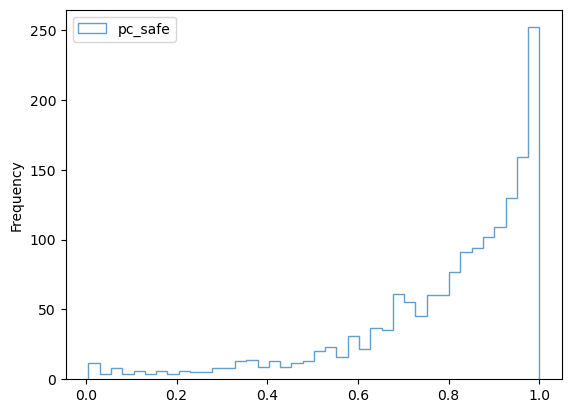

In [34]:
df_safe_water.plot(
    kind="hist",
    y="pc_safe",
    alpha=0.7,
    histtype="step",
    bins=40,
    # bw_method=0.3,
    # ind=300,
    # xlim=[0.0, 1.0]
)

In [35]:
gdf_ab3 = gpd.read_file(fp_ab3)
gdf_ab3.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.423604,0.009506,111.143026,"POLYGON ((120.96915 18.51012, 120.95867 18.463..."
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.309136,0.004725,55.303195,"POLYGON ((120.66821 18.28705, 120.66441 18.282..."
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.599295,0.006880,80.683970,"POLYGON ((120.47814 17.97717, 120.47816 17.977..."
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.483066,0.009843,115.059041,"POLYGON ((120.81318 18.53457, 120.81358 18.533..."
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.613500,0.013493,158.123132,"POLYGON ((120.61242 18.10947, 120.61200 18.106..."


In [36]:
ab2_names = gdf_ab3["ADM2_EN"].unique()
ab2_names

array(['Ilocos Norte', 'Ilocos Sur', 'La Union', 'Pangasinan', 'Batanes',
       'Cagayan', 'Isabela', 'Nueva Vizcaya', 'Quirino', 'Bataan',
       'Bulacan', 'Nueva Ecija', 'Pampanga', 'Tarlac', 'Zambales',
       'Aurora', 'Batangas', 'Cavite', 'Laguna', 'Quezon', 'Rizal',
       'Albay', 'Camarines Norte', 'Camarines Sur', 'Catanduanes',
       'Masbate', 'Sorsogon', 'Aklan', 'Antique', 'Capiz', 'Iloilo',
       'Negros Occidental', 'Guimaras', 'Bohol', 'Cebu',
       'Negros Oriental', 'Siquijor', 'Eastern Samar', 'Leyte',
       'Northern Samar', 'Samar (Western Samar)', 'Southern Leyte',
       'Biliran', 'Zamboanga del Norte', 'Zamboanga del Sur',
       'Zamboanga Sibugay', 'City of Isabela (not a province)',
       'Bukidnon', 'Camiguin', 'Lanao del Norte', 'Misamis Occidental',
       'Misamis Oriental', 'Davao del Norte', 'Davao del Sur',
       'Davao Oriental', 'Davao de Oro (Compostela Valley)',
       'Davao Occidental', 'Cotabato (North Cotabato)', 'South Cotabato',
   

In [37]:
is_special_area = gdf_ab3["ADM2_EN"] == "Special Geographic Area"

gdf_ab3.loc[is_special_area, "ADM3_EN"] = gdf_ab3.loc[is_special_area, "ADM3_EN"].str.replace("Special Geographic Area - ", "")

In [38]:
is_maguindanao = gdf_ab3["ADM2_EN"].str.contains(r"^Maguindanao", regex=True)

gdf_ab3.loc[is_maguindanao, "ADM2_EN"] = gdf_ab3.loc[is_maguindanao, "ADM2_EN"].str.replace(r"^(Maguindanao).*", "Maguindanao", regex=True)
gdf_ab3[is_maguindanao].sample(10)

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry
1611,Buluan,PH1908803,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.425493,0.004727,57.803684,"POLYGON ((124.83847 6.73426, 124.84212 6.72446..."
1597,Buldon,PH1908702,Maguindanao,PH19087,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.852394,0.031148,380.209091,"POLYGON ((124.48529 7.43861, 124.48497 7.43864..."
1609,Northern Kabuntalan,PH1908734,Maguindanao,PH19087,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.564671,0.009269,113.220305,"POLYGON ((124.44432 7.23617, 124.44434 7.23610..."
1628,Datu Anggal Midtimbang,PH1908831,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.560189,0.002732,33.382898,"POLYGON ((124.42003 7.05966, 124.41709 7.05113..."
1625,Datu Unsay,PH1908827,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.486453,0.004815,58.847292,"POLYGON ((124.42883 6.87518, 124.42916 6.88726..."
1618,South Upi,PH1908817,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.944377,0.036085,441.114271,"POLYGON ((124.19470 6.93374, 124.23943 6.92767..."
1626,Datu Abdullah Sangki,PH1908828,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.590266,0.008668,105.962154,"POLYGON ((124.56708 6.86367, 124.58075 6.85117..."
1614,Shariff Aguak (Maganoy) (Capital),PH1908808,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.396764,0.002993,36.581123,"POLYGON ((124.48638 6.86791, 124.48574 6.86687..."
1601,Parang,PH1908711,Maguindanao,PH19087,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,1.074042,0.011807,144.172687,"MULTIPOLYGON (((124.34805 7.38683, 124.34770 7..."
1603,Kabuntalan (Tumbao),PH1908714,Maguindanao,PH19087,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,Tumbao,0.496216,0.007171,87.607098,"POLYGON ((124.33906 7.17435, 124.33989 7.17339..."


In [39]:
gdf_ab3["ADDR"] = gdf_ab3["ADM2_EN"] + ", " + gdf_ab3["ADM3_EN"]
gdf_ab3.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.423604,0.009506,111.143026,"POLYGON ((120.96915 18.51012, 120.95867 18.463...","Ilocos Norte, Adams"
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.309136,0.004725,55.303195,"POLYGON ((120.66821 18.28705, 120.66441 18.282...","Ilocos Norte, Bacarra"
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.599295,0.006880,80.683970,"POLYGON ((120.47814 17.97717, 120.47816 17.977...","Ilocos Norte, Badoc"
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.483066,0.009843,115.059041,"POLYGON ((120.81318 18.53457, 120.81358 18.533...","Ilocos Norte, Bangui"
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.613500,0.013493,158.123132,"POLYGON ((120.61242 18.10947, 120.61200 18.106...","Ilocos Norte, City of Batac"


In [41]:
unique_addresses = df_safe_water["address"].unique()

gdf_ab3["MATCH"] = gdf_ab3["ADDR"].apply(
    lambda x: fzproc.extractOne(
        x, 
        unique_addresses, 
        scorer=fuzz.WRatio, 
        score_cutoff=80
    )
)

gdf_ab3[gdf_ab3["MATCH"].isna()]

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR,MATCH


In [42]:
is_duplicated = gdf_ab3["MATCH"].str[0].duplicated(keep=False)

is_double_duplicated = gdf_ab3["MATCH"].duplicated(keep=False)

is_single_duplicated = is_duplicated & ~is_double_duplicated

# Case 1: is_duplicated & ~is_double_duplicated
duplicated_addresses = gdf_ab3.loc[is_single_duplicated, "MATCH"].str[0].unique()
duplicated_addresses

for address in duplicated_addresses:
    has_address = gdf_ab3["MATCH"].str[0] == address
    
    lower_score = gdf_ab3.loc[has_address, "MATCH"].str[1].astype(int).min()
    
    has_lower_score = gdf_ab3["MATCH"].str[1] == lower_score

    must_rematch = has_address & has_lower_score

    gdf_ab3.loc[must_rematch, "MATCH"] = gdf_ab3.loc[must_rematch, "ADDR"].apply(
        lambda x: fzproc.extractOne(
            x,
            unique_addresses,
            scorer=fuzz.partial_token_sort_ratio,
            score_cutoff=80
        )
    )

gdf_ab3[is_single_duplicated]

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR,MATCH
232,City of Baliwag,PH0301403,Bulacan,PH03014,Region III (Central Luzon),PH03,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.404831,0.003845,45.759894,"POLYGON ((120.92252 14.96375, 120.92176 14.962...","Bulacan, City of Baliwag","(BULACAN, BALIUAG, 93)"
354,City of Calaca,PH0401007,Batangas,PH04010,Region IV-A (Calabarzon),PH04,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.485431,0.009609,114.860453,"POLYGON ((120.85728 14.03536, 120.85884 14.020...","Batangas, City of Calaca","(BATANGAS, CALACA, 100)"
361,Lipa City,PH0401014,Batangas,PH04010,Region IV-A (Calabarzon),PH04,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.781148,0.015999,191.281851,"POLYGON ((121.23927 13.99051, 121.24250 13.987...","Batangas, Lipa City","(BATANGAS, CITY OF LIPA, 95)"
1189,Davao City,PH1102402,Davao del Sur,PH11024,Region XI (Davao Region),PH11,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,2.808307,0.191718,2341.425940,"POLYGON ((125.54361 7.56545, 125.54331 7.54805...","Davao del Sur, Davao City","(DAVAO DEL SUR, CITY OF DAVAO, 93)"
1190,City of Digos (Capital),PH1102403,Davao del Sur,PH11024,Region XI (Davao Region),PH11,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.813907,0.021731,265.630989,"POLYGON ((125.38655 6.77894, 125.38655 6.77894...","Davao del Sur, City of Digos (Capital)","(DAVAO DEL SUR, CITY OF DIGOS (Capital), 100)"
1275,City of Manila,PH1303901,Metropolitan Manila First District,PH13039,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.600152,0.003520,41.960090,"POLYGON ((120.98508 14.63998, 120.98568 14.639...","Metropolitan Manila First District, City of Ma...","(METROPOLITAN MANILA FIRST DISTRICT, CITY OF M..."


In [43]:
double_duplicated_addresses = gdf_ab3.loc[is_double_duplicated, "MATCH"].str[0].unique()

for address in double_duplicated_addresses:
    has_address = gdf_ab3["MATCH"].str[0] == address

    gdf_ab3.loc[has_address, "MATCH"] = gdf_ab3.loc[has_address, "ADDR"].apply(
        lambda x: fzproc.extractOne(
            x,
            unique_addresses,
            scorer=fuzz.partial_token_sort_ratio,
            score_cutoff=80
        )
    )

gdf_ab3[is_double_duplicated]

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR,MATCH
384,Bacoor City,PH0402103,Cavite,PH04021,Region IV-A (Calabarzon),PH04,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.416209,0.004108,49.010326,"POLYGON ((121.01078 14.37485, 121.01068 14.374...","Cavite, Bacoor City","(CAVITE, CITY OF BACOOR, 100)"
386,Cavite City,PH0402105,Cavite,PH04021,Region IV-A (Calabarzon),PH04,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.487507,0.000995,11.873715,"MULTIPOLYGON (((120.88907 14.45577, 120.88747 ...","Cavite, Cavite City","(CAVITE, CITY OF CAVITE, 100)"
1052,Pagadian City (Capital),PH0907322,Zamboanga del Sur,PH09073,Region IX (Zamboanga Peninsula),PH09,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,1.239542,0.022526,274.721828,"MULTIPOLYGON (((123.26079 7.96602, 123.29459 7...","Zamboanga del Sur, Pagadian City (Capital)","(ZAMBOANGA DEL SUR, CITY OF PAGADIAN (Capital)..."
1059,Zamboanga City,PH0907332,Zamboanga del Sur,PH09073,Region IX (Zamboanga Peninsula),PH09,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,4.719512,0.122560,1497.154804,"MULTIPOLYGON (((122.05710 6.87274, 122.05724 6...","Zamboanga del Sur, Zamboanga City","(ZAMBOANGA DEL SUR, CITY OF ZAMBOANGA, 91)"


In [44]:
gdf_ab3[gdf_ab3["MATCH"].duplicated(keep=False)]

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR,MATCH


In [45]:
gdf_ab3["MATCH"] = gdf_ab3["MATCH"].str[0]

In [46]:
gdf_final = gdf_ab3.merge(
    df_safe_water,
    how="left",
    left_on="MATCH",
    right_on="address",
    suffixes=["_gdf", "_df"],
    validate="one_to_one"
)

gdf_final.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,...,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_level_3,pc_level_2,pc_safe_private,pc_safe,pc_unsafe,address
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,0,0,0,0,0.97093,0.00581,0.00000,0.97674,0.02326,"ILOCOS NORTE, ADAMS"
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,571,576,365,0,0.68898,0.17703,0.04234,0.90835,0.09165,"ILOCOS NORTE, BACARRA"
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,1654,289,284,0,0.40434,0.27039,0.03542,0.71015,0.28985,"ILOCOS NORTE, BADOC"
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,238,25,35,0,0.53938,0.09466,0.00870,0.64274,0.35726,"ILOCOS NORTE, BANGUI"
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,1556,830,1505,10,0.58647,0.20107,0.10845,0.89599,0.10401,"ILOCOS NORTE, CITY OF BATAC"


In [47]:
gdf_final = gdf_final.drop(columns=[
    "ADDR",
    "MATCH",
    "address"
] + geolocation_levels
).to_crs("EPSG:32651")

gdf_final.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,...,deepwell_own,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_level_3,pc_level_2,pc_safe_private,pc_safe,pc_unsafe
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,0,0,0,0,0,0.97093,0.00581,0.00000,0.97674,0.02326
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,1475,571,576,365,0,0.68898,0.17703,0.04234,0.90835,0.09165
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,1509,1654,289,284,0,0.40434,0.27039,0.03542,0.71015,0.28985
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,497,238,25,35,0,0.53938,0.09466,0.00870,0.64274,0.35726
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,5545,1556,830,1505,10,0.58647,0.20107,0.10845,0.89599,0.10401


In [48]:
fp_output = OUTPUT_DIR / "PH_CookingWaterAccess_PSA-CPH_2020.shp"

gdf_final.to_file(fp_output)

C:\Users\HOWARD\AppData\Local\Temp\ipykernel_1388\3773787071.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_final.to_file(fp_output)
